This tutorial will cover the basics up to predicting the 21-cm power spectrum and global signal. We will start by importing the necessary packages (Zeus, numpy, class)

In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np


#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

In [2]:
#set up your parameters here, as an example the CDM (reduced) density
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
ClassyCosmo = zeus21.runclass(CosmoParams_input)
print('CLASS has run, we store the cosmology.')

CLASS has run, we store the cosmology.


In [3]:
#define all cosmology (including derived) parameters, and save them to the CosmoParams structure
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(CosmoParams, ClassyCosmo)
print('Correlation functions saved.')
HMFintclass = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
print('HMF interpolator built. This ends the cosmology part -- moving to astrophysics.')

#set up your astro parameters too, here the peak of f*(Mh) as an example
AstroParams = zeus21.Astro_Parameters(CosmoParams)


ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
zlist = CoeffStructure.zintegral
print('SFRD and coefficients stored. Move ahead.')

RSDMODE = 1 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PS21 = zeus21.Power_Spectra(CosmoParams, ClassyCosmo, CorrFClass, CoeffStructure, RSD_MODE = RSDMODE)
print('Computed the 21-cm power spectrum.')
klist = PS21.klist_PS

Correlation functions saved.
HMF interpolator built. This ends the cosmology part -- moving to astrophysics.
SFRD and coefficients stored. Move ahead.
Computed the 21-cm power spectrum.


0.9999121543058604


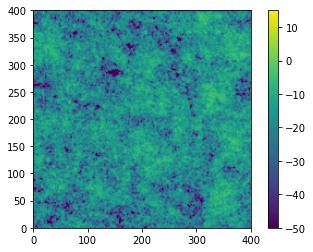

In [135]:
#mode 1: just T21 purely lognormal
import powerbox as pbox
from scipy.interpolate import interp1d

zchoose=13.; _iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

klist = PS21.klist_PS
P21 = PS21.Deltasq_T21[_iz,:]/klist**3*(2*np.pi**2)
T21global = CoeffStructure.T21avg[_iz]
P21norm = P21/T21global**2

P21norminterp = interp1d(klist,P21norm,fill_value=0.0,bounds_error=False)

Lbox=400.
Nbox=200
#pb = pbox.PowerBox(
pb = pbox.LogNormalPowerBox(
    N=Nbox,                     # Number of grid-points in the box
    dim=3,                     # 3D box
    pk = lambda k: P21norminterp(k), # The power-spectrum
    boxlength = Lbox,           # Size of the box (sets the units of k in pk)
    seed = 1605                # Set a seed to ensure the box looks the same every time (optional)
)



T21map = T21global * (1 + pb.delta_x() )
print(np.mean(T21map)/T21global)
_islice = 0
plt.imshow(T21map[_islice],extent=(0,Lbox,0,Lbox),vmin=-50,vmax=15)
plt.colorbar()
plt.show()


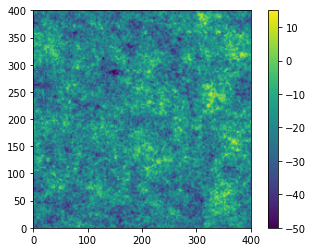

In [134]:
pbG = pbox.PowerBox(
    N=Nbox,                     # Number of grid-points in the box
    dim=3,                     # 3D box
    pk = lambda k: P21norminterp(k), # The power-spectrum
    boxlength = Lbox,           # Size of the box (sets the units of k in pk)
    seed = 1605                # Set a seed to ensure the box looks the same every time (optional)
)
T21mapG = T21global * (1 + pbG.delta_x() )
plt.imshow(T21mapG[_islice],extent=(0,Lbox,0,Lbox),vmin=-50,vmax=15)
plt.colorbar()
plt.show()

-2.76401124210679e-18


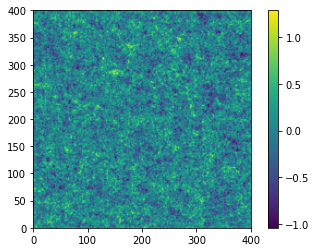

In [136]:
#option 2: make density and other maps
import powerbox as pbox
from scipy.interpolate import interp1d

zchoose=12.; _iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

klist = PS21.klist_PS
Pd = PS21.Deltasq_d_lin[_iz,:]/klist**3*(2*np.pi**2)
Pdinterp = interp1d(klist,Pd,fill_value=0.0,bounds_error=False)


Lbox=400.
Nbox=200

pb = pbox.PowerBox(
    N=Nbox,                     # Number of grid-points in the box
    dim=3,                     # 3D box
    pk = lambda k: Pdinterp(k), # The power-spectrum
    boxlength = Lbox,           # Size of the box (sets the units of k in pk)
    seed = 1605                # Set a seed to ensure the box looks the same every time (optional)
)


deltamap = pb.delta_x()

print(np.mean(deltamap))
_islice = 0
plt.imshow(deltamap[_islice],extent=(0,Lbox,0,Lbox))
plt.colorbar()
plt.show()


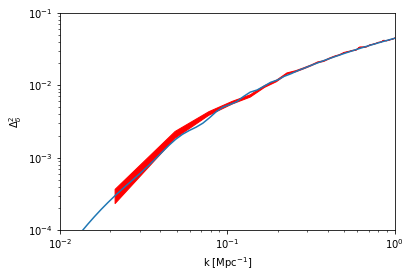

In [163]:
Pdout, kdout, errPd = pbox.get_power(deltamap-np.mean(deltamap),boxlength=Lbox,get_variance=True)

plt.loglog(klist,PS21.Deltasq_d_lin[_iz,:])
plt.fill_between(kdout,(Pdout+np.sqrt(errPd))*kdout**3/(2*np.pi**2),(Pdout-np.sqrt(errPd))*kdout**3/(2*np.pi**2),color='red')

plt.xlim(1e-2,1);
plt.ylim(1e-4,1e-1);
plt.xlabel('k [Mpc$^{-1}$]');
plt.ylabel('$\Delta^2_\delta$');

In [211]:
from pyfftw import empty_aligned as empty

def powerboxCtoR(pbobject,mapkin = None):

    realmap = empty((pbobject.N,) * pbobject.dim, dtype='complex128')
    if (mapkin is None):
        realmap[...] = pbobject.delta_k()
    else:
        realmap[...] = mapkin
    realmap[...] = pbobject.V * pbox.dft.ifft(realmap, L=pbobject.boxlength, a=pbobject.fourier_a, b=pbobject.fourier_b)[0]
    realmap = np.real(realmap)

    return realmap

In [205]:
#better to use the cross to keep sign, at linear level same 
DeltasqdT21 = CoeffStructure.T21avg * ( PS21._betaxa * PS21.Deltasq_dxa_lin.T + PS21._betaT * PS21.Deltasq_dTx_lin.T+ PS21._betad * PS21.Deltasq_d_lin.T )
PdT21 = DeltasqdT21[:,_iz]/klist**3*(2*np.pi**2)

powerratioint = interp1d(klist,PdT21/Pd,fill_value=0.0,bounds_error=False)

P21 = PS21.Deltasq_T21_lin[_iz,:]/klist**3*(2*np.pi**2)
powerratioint = interp1d(klist,np.sqrt(P21/Pd),fill_value=0.0,bounds_error=False)

In [202]:
# pb21lin = pbox.PowerBox(
#     N=Nbox,                     # Number of grid-points in the box
#     dim=3,                     # 3D box
#     pk = lambda k: Pdinterp(k)*powerratioint(k), # The power-spectrum
#     boxlength = Lbox,           # Size of the box (sets the units of k in pk)
#     seed = 1605                # Set a seed to ensure the box looks the same every time (optional)
# )

# T21maplin = T21global + pb21lin.delta_x()


# plt.imshow(T21maplin[_islice],extent=(0,Lbox,0,Lbox))
# plt.colorbar()
# plt.show()

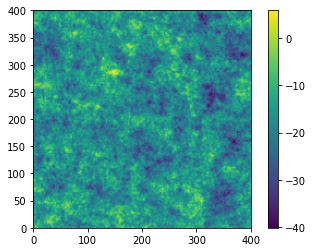

In [212]:
deltak = pb.delta_k()

powerratio = powerratioint(pb.k())
T21lin_k = powerratio * deltak
T21maplin= T21global + powerboxCtoR(pb,mapkin = T21lin_k)

plt.imshow(T21maplin[_islice],extent=(0,Lbox,0,Lbox))
plt.colorbar()
plt.show()

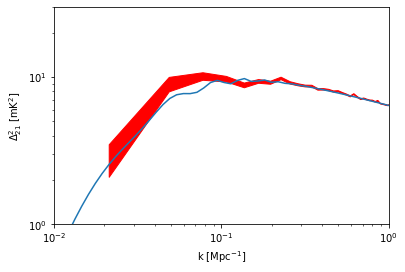

In [215]:
Pdout, kdout, errPd = pbox.get_power(T21maplin-np.mean(T21maplin),boxlength=Lbox,get_variance=True)

plt.loglog(klist,P21*klist**3/(2*np.pi**2),'-')
plt.fill_between(kdout,(Pdout+np.sqrt(errPd))*kdout**3/(2*np.pi**2),(Pdout-np.sqrt(errPd))*kdout**3/(2*np.pi**2),color='red')

plt.xlim(1e-2,1);
plt.ylim(1,30);
plt.xlabel('k [Mpc$^{-1}$]');
plt.ylabel('$\Delta^2_{21}$ [mK$^2$]');

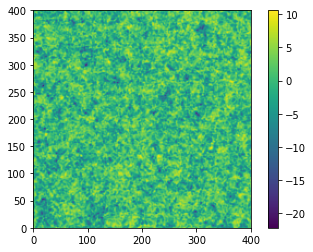

In [222]:
#add the nonlinear part
#NOTE: its not guaranteed to work, excess power can be negative in some cases! Not for each component xa, Tk, but yes for T21

excesspower21 = (PS21.Deltasq_T21[_iz,:]-PS21.Deltasq_T21_lin[_iz,:])/klist**3*(2*np.pi**2)

lognormpower = interp1d(klist,excesspower21/T21global**2,fill_value=0.0,bounds_error=False)
#G or logG? TODO revisit
pbe = pbox.LogNormalPowerBox(
    N=Nbox,                     
    dim=3,                     
    pk = lambda k: lognormpower(k), 
    boxlength = Lbox,           
    seed = 1605+1                # uncorrelated
)

T21mapNL = T21global*pbe.delta_x()


plt.imshow(T21mapNL[_islice],extent=(0,Lbox,0,Lbox))
plt.colorbar()
plt.show()

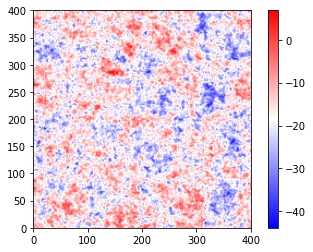

In [227]:
T21maptot = T21maplin +  T21mapNL


plt.imshow(T21maptot[_islice],extent=(0,Lbox,0,Lbox),cmap='bwr')
plt.colorbar()
plt.show()

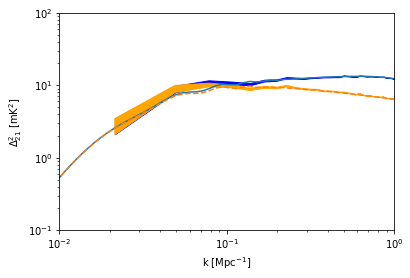

In [224]:
Pdout, kdout, errPd = pbox.get_power(T21maptot-np.mean(T21maptot),boxlength=Lbox,get_variance=True)
Pdout_lin, kdout_lin, errPd_lin = pbox.get_power(T21maplin-np.mean(T21maplin),boxlength=Lbox,get_variance=True)

plt.loglog(klist,PS21.Deltasq_T21[_iz,:])
plt.loglog(klist,PS21.Deltasq_T21_lin[_iz,:],'--')
plt.fill_between(kdout,(Pdout+np.sqrt(errPd))*kdout**3/(2*np.pi**2),(Pdout-np.sqrt(errPd))*kdout**3/(2*np.pi**2),color='blue')
plt.fill_between(kdout_lin,(Pdout_lin+np.sqrt(errPd_lin))*kdout_lin**3/(2*np.pi**2),(Pdout_lin-np.sqrt(errPd_lin))*kdout_lin**3/(2*np.pi**2),color='orange')

plt.xlim(1e-2,1);
plt.ylim(1e-1,1e2);
plt.xlabel('k [Mpc$^{-1}$]');
plt.ylabel('$\Delta^2_{21}$ [mK$^2$]');

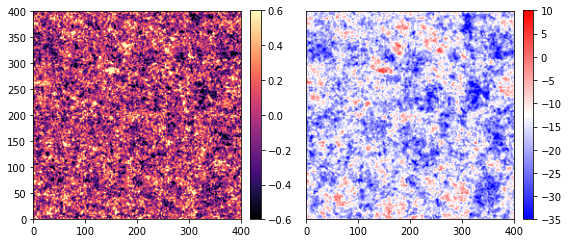

In [274]:
#f = plt.figure(figsize = (10,8))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

im=ax[0].imshow(deltamap[_islice],extent=(0,Lbox,0,Lbox),cmap='magma',vmin=-0.6,vmax=0.6)
cbar1 = fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

im=ax[1].imshow(T21maptot[_islice],extent=(0,Lbox,0,Lbox),cmap='bwr',vmin=-35,vmax=10)
ax[1].set_yticks([])
cbar2 = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)


fig.tight_layout()
plt.show()

12.445031716111444
20.790903909942152
52.795780298818634


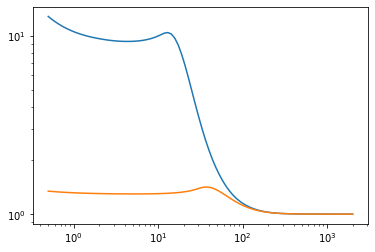

In [122]:
_iz=22; print(zlist[_iz])
_ir = 40;print(CoeffStructure.Rtabsmoo[_ir]);  corrfunc = np.diag(CorrFClass.xi_RR_CF[:,:,_ir])
plt.loglog(CoeffStructure.Rtabsmoo,np.exp(CoeffStructure.gamma_index2D[_iz]*corrfunc)**2-(CoeffStructure.gamma_index2D[_iz]*corrfunc)**2)
_ir = 50;print(CoeffStructure.Rtabsmoo[_ir]);  corrfunc = np.diag(CorrFClass.xi_RR_CF[:,:,_ir])
plt.loglog(CoeffStructure.Rtabsmoo,np.exp(CoeffStructure.gamma_index2D[_iz]*corrfunc)**2-(CoeffStructure.gamma_index2D[_iz]*corrfunc)**2)

In [115]:
print(corrfunc[15])
print(CorrFClass.xi_RR_CF[15,15,_ir])

4.206427337571661
4.206427337571661


In [ ]:
old too

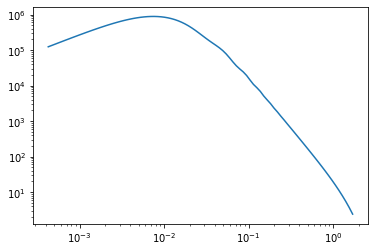

In [4]:
import powerbox as pbox
from scipy.interpolate import interp1d

zchoose=12.; _iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

klist = PS21.klist_PS
P21 = PS21.Deltasq_T21[_iz,:]/klist**3*(2*np.pi**2)
T21global = CoeffStructure.T21avg[_iz]
P21norm = P21/T21global**2

plt.loglog(klist,P21norm)
# P21interp = interp1d(klist,P21norm,fill_value=0.0,bounds_error=False)

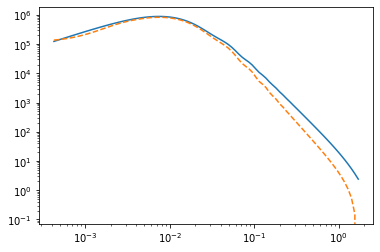

In [5]:
#define T21 = T21bar e^etatilde, etatilde is Gaussian

r21, xi21 = CorrFClass._xif(P21, extrap=False)
xieta = np.log(1 + xi21/T21global**2)

keta, Peta = PS21.get_Pk_from_xi(r21,xieta)
Peta = np.fmax(Peta,0.0)

plt.loglog(klist,P21norm)
plt.loglog(keta,Peta,'--')

Petainterp = interp1d(keta,Peta,fill_value=0.0,bounds_error=False)

0.9999783616957469


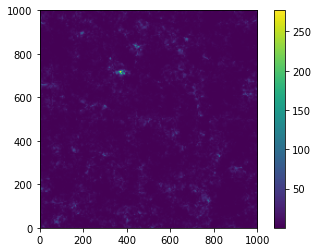

In [38]:
Lbox=1000.
Nbox=200

pb = pbox.PowerBox(
    N=Nbox,                     # Number of grid-points in the box
    dim=3,                     # 3D box
    pk = lambda k: Petainterp(k), # The power-spectrum
    boxlength = Lbox,           # Size of the box (sets the units of k in pk)
    seed = 1605                # Set a seed to ensure the box looks the same every time (optional)
)


etamap = pb.delta_x()
sigmaetasq = np.var(etamap)

T21map = T21global * np.exp(etamap - sigmaetasq/2.)
print(np.mean(T21map)/T21global)
_islice = 0
plt.imshow(T21map[_islice],extent=(0,Lbox,0,Lbox))
plt.colorbar()
plt.show()


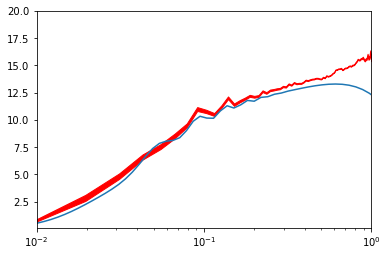

In [39]:
Pout, kout, err = pbox.get_power(T21map-np.mean(T21map),boxlength=Lbox,get_variance=True)


plt.semilogx(klist,P21*klist**3/(2*np.pi**2))
plt.fill_between(kout,(Pout+np.sqrt(err))*kout**3/(2*np.pi**2),(Pout-np.sqrt(err))*kout**3/(2*np.pi**2),color='red')

plt.xlim(1e-2,1);
plt.ylim(1e-1,20);

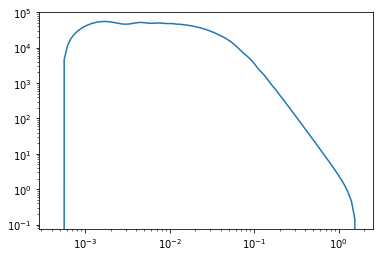

In [97]:
#generate densities too, with approximate correlation correctly
#define eta = a* delta + epsilon in Fourier space, with:
#a = T21 P_eta/P_dT21, and
# P_epsilon = P_d - a^2 P_eta. Let's first get Peta

DeltasqdT21 = CoeffStructure.T21avg * ( PS21._betaxa * PS21.Deltasq_dxa.T + PS21._betaT * PS21.Deltasq_dTx.T+ PS21._betad * PS21.Deltasq_d.T )
PdT21 = DeltasqdT21.T /klist**3*(2*np.pi**2)

Deltasqd = PS21.Deltasq_d
Pd = Deltasqd /klist**3*(2*np.pi**2)

afactor = Peta/PdT21 * T21global
Pepsilon = Peta - afactor**2 * Pd

plt.loglog(keta,Pepsilon[_iz],'-')
Pepsiloninterp = interp1d(keta,Pepsilon[_iz],fill_value=0.0,bounds_error=False)

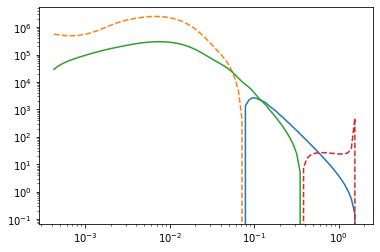

In [104]:
plt.loglog(keta,Pepsilon[0],'-')
plt.loglog(keta,-Pepsilon[0],'--')

plt.loglog(keta,Pepsilon[22],'-')
plt.loglog(keta,-Pepsilon[22],'--')



In [88]:
etamap = pb.delta_x()
from pyfftw import empty_aligned as empty

def powerboxCtoR(pbobject,mapkin = None):

    realmap = empty((pbobject.N,) * pbobject.dim, dtype='complex128')
    if (mapkin is None):
        realmap[...] = pbobject.delta_k()
    else:
        realmap[...] = mapkin
    realmap[...] = pbobject.V * pbox.dft.ifft(realmap, L=pbobject.boxlength, a=pbobject.fourier_a, b=pbobject.fourier_b)[0]
    realmap = np.real(realmap)

    return etamaptry

etamaptry = powerboxCtoR(pb)
etamaptry = powerboxCtoR(pb, mapkin=pb.delta_k() )
print( (etamaptry/etamap) [0])

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


In [89]:
pbeta = pbox.PowerBox(
    N=Nbox,                     # Number of grid-points in the box
    dim=3,                     # 3D box
    pk = lambda k: Pepsiloninterp(k), # The power-spectrum
    boxlength = Lbox,           # Size of the box (sets the units of k in pk)
    seed = 1606                # Set a seed to ensure the box looks the same every time (optional)
)

epsilonmap_k = pbeta.delta_k()
etamap_k = pb.delta_k()



_afactorint = interp1d(keta,afactor[_iz],fill_value=np.inf,bounds_error=False)
_currafactor = _afactorint(pb.k())
print(_currafactor.shape)
print(etamap_k.shape)
print(epsilonmap_k.shape)

deltamap_k = (etamap_k-epsilonmap_k)/_currafactor

deltamap = powerboxCtoR(pb, mapkin=deltamap_k )
print(deltamap.shape)

(200, 200, 200)
(200, 200, 200)
(200, 200, 200)
(200, 200, 200)


array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., -0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., -0.,  0.,  0.],
        [ 0., -0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.

-1.455191522836685e-17


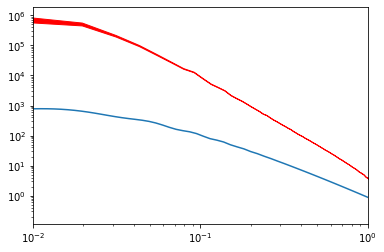

In [95]:
Pdout, kdout, errPd = pbox.get_power(deltamap-np.mean(deltamap),boxlength=Lbox,get_variance=True)
print(np.mean(deltamap))

plt.loglog(klist,Pd[_iz])
plt.fill_between(kdout,(Pdout+np.sqrt(errPd)),(Pdout-np.sqrt(errPd)),color='red')

plt.xlim(1e-2,1);
#plt.ylim(1e-1,20);

(array([  21823.,  152102.,  413438.,  804788., 1328594., 1949909.,
        1823420., 1125056.,  341093.,   39777.]),
 array([0.        , 0.10882796, 0.21765592, 0.32648389, 0.43531185,
        0.54413981, 0.65296777, 0.76179573, 0.87062369, 0.97945166,
        1.08827962]),
 <BarContainer object of 10 artists>)

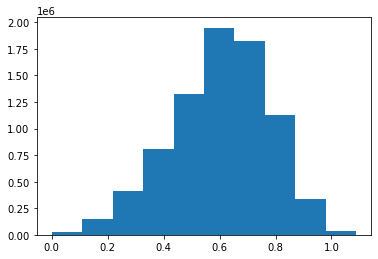

In [50]:
plt.hist(pb.k().flatten())

In [ ]:
stop

In [ ]:
_kforsign = 0.1; _iksign1 = min(range(len(klist)), key=lambda i: np.abs(klist[i]-_kforsign))
_kforsign = 0.5; _iksign2 = min(range(len(klist)), key=lambda i: np.abs(klist[i]-_kforsign))

DeltasqdT21 = CoeffStructure.T21avg * ( PS21._betaxa * PS21.Deltasq_dxa.T + PS21._betaT * PS21.Deltasq_dTx.T+ PS21._betad * PS21.Deltasq_d.T )
DeltasqdT21_lin = CoeffStructure.T21avg * (PS21._betaxa * PS21.Deltasq_dxa_lin.T + PS21._betaT * PS21.Deltasq_dTx_lin.T+ PS21._betad * PS21.Deltasq_d_lin.T )

sign_z_k = np.sign(DeltasqdT21)

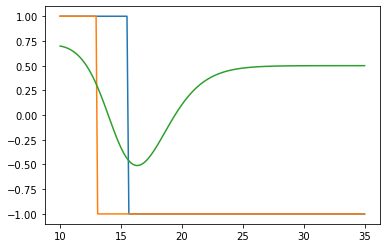

In [ ]:
plt.plot(zlist,sign_z_k[_iksign1])
plt.plot(zlist,sign_z_k[_iksign2])
plt.plot(zlist,CoeffStructure.T21avg/100+0.5)

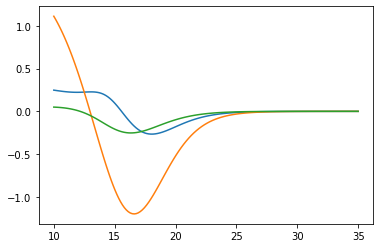

In [ ]:
plt.plot(zlist,DeltasqdT21[_iksign1])
plt.plot(zlist,DeltasqdT21[_iksign2])
plt.plot(zlist,CoeffStructure.T21avg/400)

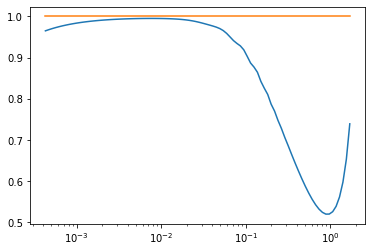

In [ ]:
plt.semilogx(klist, (DeltasqdT21.T**2/PS21.Deltasq_d/PS21.Deltasq_T21)[_iz] )
plt.semilogx(klist, (DeltasqdT21_lin.T**2/PS21.Deltasq_d_lin/PS21.Deltasq_T21_lin)[_iz] )

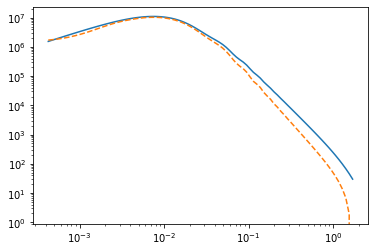

3.531535958778407 3.531535958778407


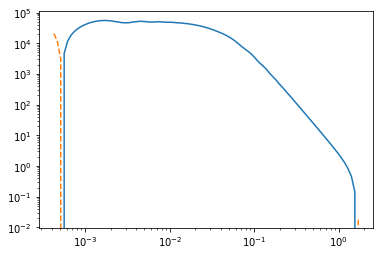

In [ ]:
DeltasqdT21 = CoeffStructure.T21avg * ( PS21._betaxa * PS21.Deltasq_dxa.T + PS21._betaT * PS21.Deltasq_dTx.T+ PS21._betad * PS21.Deltasq_d.T )
PdT21 = DeltasqdT21.T /klist**3*(2*np.pi**2)
#Pdeta =  PdT21/T21global

print(CoeffStructure.T21avg[_iz],T21global)

Deltasqd = PS21.Deltasq_d
Pd = Deltasqd /klist**3*(2*np.pi**2)
#Pepsilon2 = Pd - Pdeta**2/Peta

# afactor = PdT21/Peta/T21global
# Pepsilonno = Pd - PdT21**2/Peta/T21global**2


afactor = Peta/PdT21 * T21global
Pepsilon = Peta - afactor**2 * Pd

plt.loglog(keta,Pepsilon[_iz],'-')
plt.loglog(keta,-Pepsilon[_iz],'--')

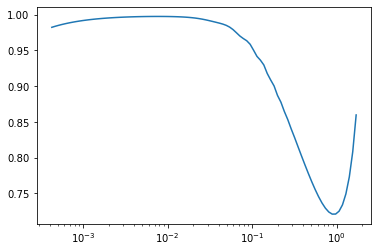

In [ ]:
plt.semilogx(klist, PdT21[_iz]/np.sqrt(P21*Pd[_iz] ) )


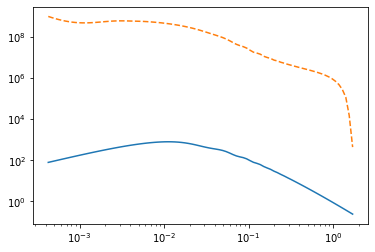

In [ ]:
plt.loglog(keta,Pd[_iz],'-')
plt.loglog(keta,afactor[_iz]**2 * Peta[_iz],'--')

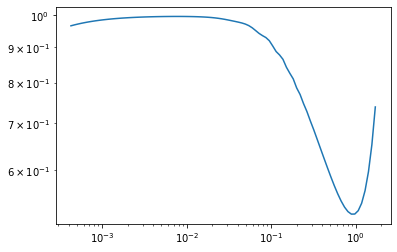

In [ ]:
plt.loglog(keta,PdT21[_iz]**2/Pd[_iz]/P21,'-')


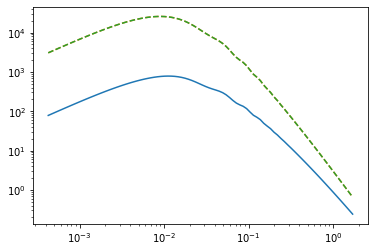

In [ ]:
plt.loglog(keta,Pd[_iz],'-')
plt.loglog(keta,Peta*PdT21[_iz]/T21global/Peta,'--')
plt.loglog(keta,PdT21[_iz]/T21global,'--')

In [ ]:
stop

The CoeffStructure holds all the information needed to find the 21-cm signal during cosmic dawn. It has saved the 21-cm global signal, the Wouthuysen-Field coupling, and all temperatures. It also has the effective biases $\gamma_R$ for all $R$ (which will be used for the power spectrum below). This structure also has ancillary data like the evolution of the SFRD and Nion. If you want to learn what else the CoeffStructure holds, just do dir(CoeffStructure)

Let us start by plotting the global signal.

(10.0, 25.0)

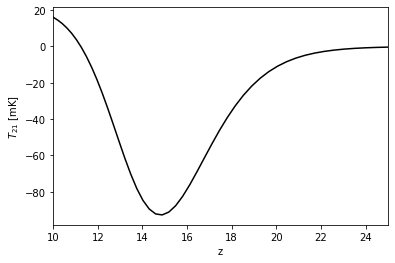

In [ ]:
plt.plot(zlist,CoeffStructure.T21avg, 'k')
plt.xlabel(r'z');
plt.ylabel(r'$T_{21}$ [mK]');
plt.xlim([10, 25])

It has the usual absorption trough around $z\sim15$ that we know and love (given so far we only have atomic-cooling haloes), and turns into emission at $z\sim11$. Since we're stopping at `ZMIN=10` we don't get to see the bulk of reionization, but it's stored in CoeffStructure.xHI_avg.

Let us plot the relevant temperatures too. Here is the CMB temperature $T_{\rm CMB}$; the gas kinetic temperature $T_k$, which has an adiabatic/cosmological and an X-ray component; and the spin temperature $T_S$, which has the WF coupling in it (and we store its inverse in the code).

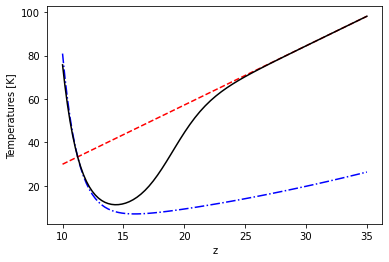

In [ ]:
plt.plot(zlist,CoeffStructure.T_CMB,'r--')
plt.plot(zlist,CoeffStructure.Tk_avg,'b-.')
plt.plot(zlist,1.0/CoeffStructure._invTs_avg,'k')
plt.xlabel(r'z');
plt.ylabel(r'Temperatures [K]');

This lines up with our expectation from the 21-cm global signal above. Absorption begins when $T_S$ departs from $T_{\rm CMB}$, at $z\sim 20$, as it begins to couple to $T_k$. It turns into emission at $z\sim 11$ when $T_S\sim T_k > T_{\rm CMB}$. Full WF coupling only occurs after there has been some X-ray heating, so we don't get a deep 21-cm trough for this model. This would be different with a lower X-ray luminosity $L_X$ as we will see below.

Let's move now to the 21-cm fluctuations.

In [ ]:
RSDMODE = 1 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PS21 = zeus21.Power_Spectra(CosmoParams, ClassyCosmo, CorrFClass, CoeffStructure, RSD_MODE = RSDMODE)
print('Computed the 21-cm power spectrum.')

Computed the 21-cm power spectrum.


(1, 200)

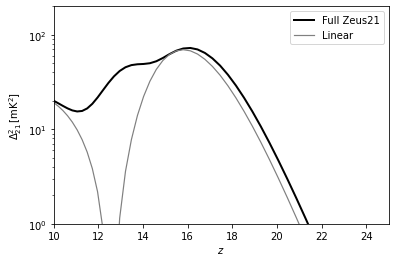

In [ ]:
#choose a k to plot
klist = PS21.klist_PS
kchoose=0.3;
_ik = min(range(len(klist)), key=lambda i: np.abs(klist[i]-kchoose))

plt.semilogy(zlist,PS21.Deltasq_T21[:,_ik], color='k', linewidth=2.0)
plt.semilogy(zlist,PS21.Deltasq_T21_lin[:,_ik], color='gray', linewidth=1.2)

plt.xlabel(r'$z$');
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');
plt.legend([r'Full Zeus21', r'Linear'])

plt.xlim([10, 25])
plt.ylim([1,200])

This shows the evolution of the fluctuations at a particular scale (i.e., wavenumber $k$). We have shown the full result from Zeus21, as well as the linear approximation (which is also stored). We can flip the script now and show the 21-cm power against wavenumber at a particular redshift.

(1, 200)

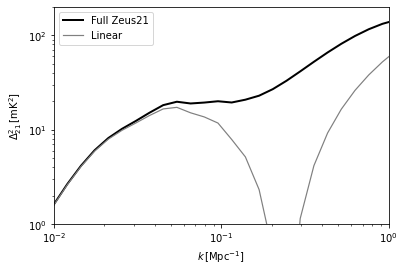

In [ ]:
#choose a z to plot
zchoose=13.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

plt.loglog(klist,PS21.Deltasq_T21[_iz], color='k', linewidth=2.0)
plt.loglog(klist,PS21.Deltasq_T21_lin[_iz], color='gray', linewidth=1.2)

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');
plt.legend([r'Full Zeus21', r'Linear'])

plt.xlim([1e-2,1])
plt.ylim([1,200])

This was for a specific set of astro+cosmo parameters. Let's do a different example with lower X-ray luminosity (which we expect will produce a deeper cosmic dawn absorption). This is controlled through the free parameter L40_xray (luminosity per unit SFR in units of 10^40 erg/s/SFR), with a fiducial value of 3.0. Let's lower it to 1.0 and see what happens.

In [ ]:
AstroParams_lowLX = zeus21.Astro_Parameters(CosmoParams, epsstar=epsilon_star, L40_xray=1.0)
CoeffStructure_lowLX = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams_lowLX, HMFintclass, zmin=ZMIN)
PS21_lowLX = zeus21.Power_Spectra(CosmoParams, ClassyCosmo, CorrFClass, CoeffStructure_lowLX, RSD_MODE = RSDMODE)

Note that we can re-run the astrophysics part only, so it should take ~few seconds in a laptop. Let's plot the global signal and fluctuations comparing with the fiducial case.

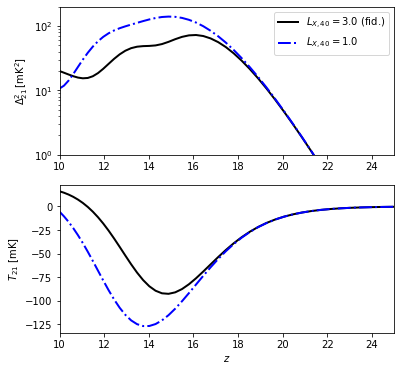

In [ ]:
f = plt.figure(figsize = (6,6))

ax = f.add_subplot(211)

plt.semilogy(zlist,PS21.Deltasq_T21[:,_ik], 'k', linewidth=2.0)
plt.semilogy(zlist,PS21_lowLX.Deltasq_T21[:,_ik], 'b-.', linewidth=2.0)

plt.ylabel(r'$\Delta^2_{21}\,\rm[mK^2]$');
plt.legend([r'$L_{X,40} = 3.0$ (fid.)', r'$L_{X,40} = 1.0$'])
plt.xlim([10, 25]);
plt.ylim([1,200]);

ax = f.add_subplot(212)

plt.plot(zlist,CoeffStructure.T21avg, 'k', linewidth=2.0)
plt.plot(zlist,CoeffStructure_lowLX.T21avg, 'b-.', linewidth=2.0)

plt.xlabel(r'$z$');
plt.ylabel(r'$T_{21}$ [mK]');

plt.xlim([10, 25]);

Just as we expected! Lowering the X-ray luminosity (blue) makes for a deeper 21-cm global absorption, and larger 21-cm fluctuations too. By $z\sim 10$ there is still enough heating to raise the 21-cm signal near absorption. We can confirm this by plotting the spin temperature and comparing against the `standard' case

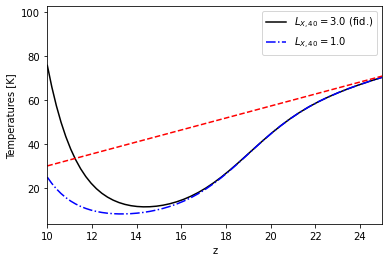

In [ ]:
plt.plot(zlist,1.0/CoeffStructure._invTs_avg,'k')
plt.plot(zlist,1.0/CoeffStructure_lowLX._invTs_avg,'b-.')
plt.plot(zlist,CoeffStructure.T_CMB,'r--')
plt.xlabel(r'z');
plt.ylabel(r'Temperatures [K]');
plt.legend([r'$L_{X,40} = 3.0$ (fid.)', r'$L_{X,40} = 1.0$'])
plt.xlim([10, 25]);

You're now ready to calculate any 21-cm power spectrum or global signal that you want!